# # Detecção de Anomalias em Transações Financeiras
# 
# ## Objetivo: Identificar transações fraudulentas com foco em F2-Score
# 
# **Dataset**: Credit Card Fraud Detection (Kaggle)
# **Diferencial**: Análise do trade-off entre detectar fraudes e incomodar clientes

# Configurações de ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report,precision_recall_curve, roc_curve, auc, fbeta_score, precision_score, recall_score)
import warnings
warnings.filterwarnings('ignore')

# Configurando visualizações

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


# Carregamento do dataset e análise exploratória

In [3]:
df = pd.read_csv('creditcard.csv')
print(f"Shape do dataset: {df.shape}")
print(f"\nPrimeiras linhas do dataset:\n{df.head()}")
print(df.head())

Shape do dataset: (284807, 31)

Primeiras linhas do dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.13

# Analise do desbalanceamento


Análise Exploratória dos Dados (EDA)
Transações normais (Classe 0): 284,315 (99.83%)
Transações fraudulentas (Classe 1): 492 (0.17%)


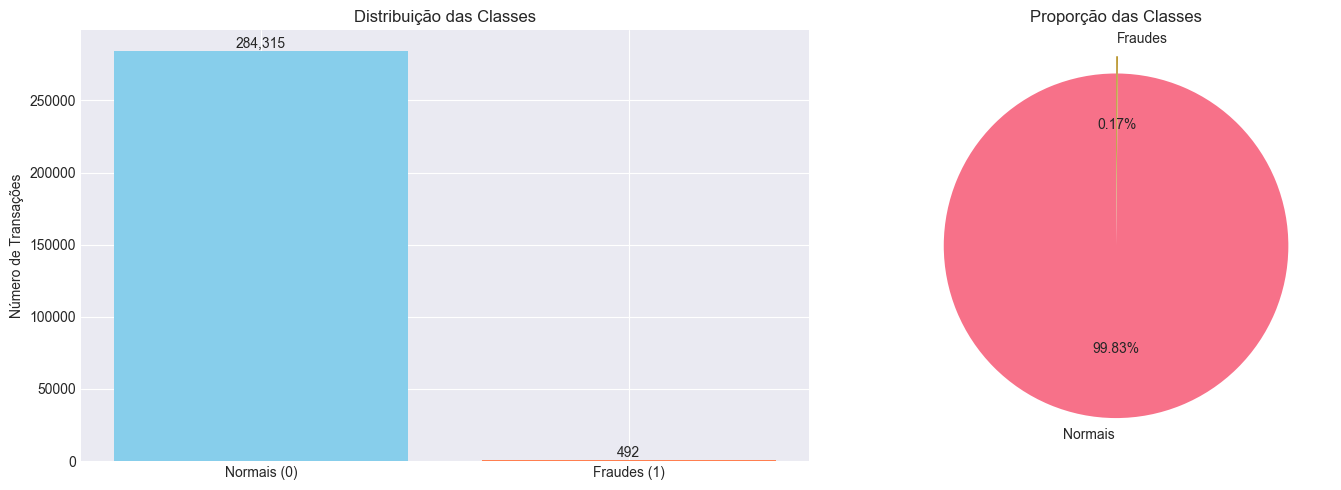

In [4]:
print("\n" + "="*50)
print("Análise Exploratória dos Dados (EDA)")
print("="*50)

# Distribuição das classes
class_counts = df['Class'].value_counts()
class_percentage = df['Class'].value_counts(normalize=True) * 100

print(f"Transações normais (Classe 0): {class_counts[0]:,} ({class_percentage[0]:.2f}%)")
print(f"Transações fraudulentas (Classe 1): {class_counts[1]:,} ({class_percentage[1]:.2f}%)")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de barras
axes[0].bar(['Normais (0)', 'Fraudes (1)'], class_counts.values, 
           color=['skyblue', 'coral'])
axes[0].set_title('Distribuição das Classes')
axes[0].set_ylabel('Número de Transações')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Gráfico de pizza (realce para fraudes detectadas)
explode = (0, 0.1)  # Destacar as fraudes
axes[1].pie(class_counts.values, labels=['Normais', 'Fraudes'], 
          explode=explode, autopct='%1.2f%%', startangle=90)
axes[1].set_title('Proporção das Classes')

plt.tight_layout()
plt.show()

# Analise de valores faltantes e estatísticas


Análise Exploratória dos Dados (EDA)
Valores nulos por coluna:
0

Estatísticas de 'Amount' (valor da transação):
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


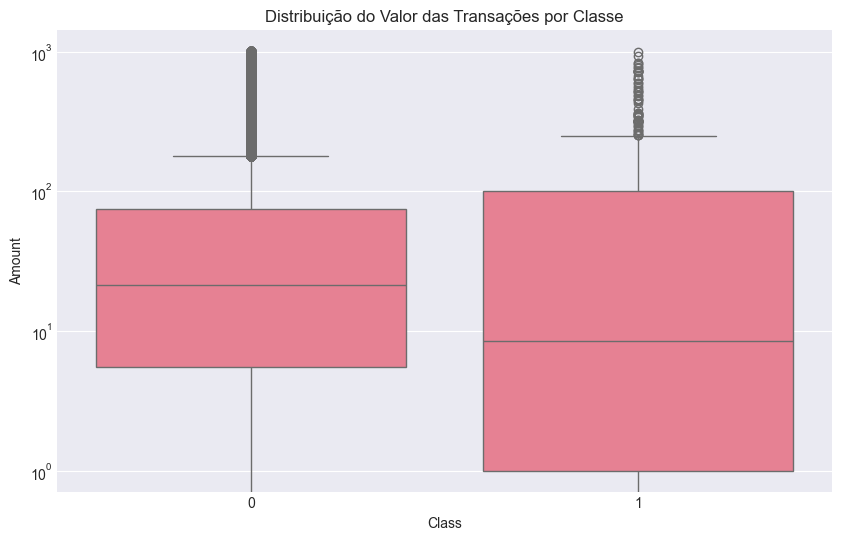

In [5]:
print("\n" + "="*50)
print("Análise Exploratória dos Dados (EDA)")
print("="*50)

print(f"Valores nulos por coluna:")
print(df.isnull().sum().sum())  # Esse dataset não tem nulos por se tratar de um dataset pré-processado, de qualquer forma por boas praticas irei verificar
print(f"\nEstatísticas de 'Amount' (valor da transação):")
print(df['Amount'].describe())

# Boxplot do valor das transações por classe
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df[df['Amount'] < df['Amount'].quantile(0.99)])
plt.title('Distribuição do Valor das Transações por Classe')
plt.yscale('log')
plt.show()

# Pre-processamento

In [6]:
# Separar features e target
X = df.drop('Class', axis=1)
y = df['Class']

# Normalizar 'Amount' e 'Time'
scaler = StandardScaler()
X[['Amount', 'Time']] = scaler.fit_transform(X[['Amount', 'Time']])

print("Features normalizadas com sucesso!")
print(f"\nDimensões: X={X.shape}, y={y.shape}")

# %% [code]
# Divisão estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Manter proporção das classes
)

print(f"Tamanho do treino: {X_train.shape}")
print(f"Tamanho do teste: {X_test.shape}")
print(f"\nProporção no treino: {y_train.value_counts(normalize=True).values}")
print(f"Proporção no teste: {y_test.value_counts(normalize=True).values}")


Features normalizadas com sucesso!

Dimensões: X=(284807, 30), y=(284807,)
Tamanho do treino: (227845, 30)
Tamanho do teste: (56962, 30)

Proporção no treino: [0.99827075 0.00172925]
Proporção no teste: [0.99827955 0.00172045]


# Modelos de detecção de possiveis anomalias

In [7]:
# Função para avaliação detalhada
def avaliar_modelo(y_true, y_pred, nome_modelo, custo_fraude=1000, custo_falso_positivo=50):
    """
    Avaliação completa com métricas de negócio
    """
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Métricas básicas
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f2 = (1 + 2**2) * (precision * recall) / (4 * precision + recall) if (4 * precision + recall) > 0 else 0
    
    # Métricas de negócio
    custo_total = (fn * custo_fraude) + (fp * custo_falso_positivo)
    fraude_detectada = f"{tp}/{tp+fn} ({recall:.2%})"
    precisao_alerta = f"{precision:.2%}"
    
    # Display
    print(f"\n{'='*60}")
    print(f"AVALIAÇÃO: {nome_modelo}")
    print(f"{'='*60}")
    print(f"Matriz de Confusão:")
    print(f"                Predito 0   Predito 1")
    print(f"Real 0 (Normal)   {tn:6d}        {fp:6d}")
    print(f"Real 1 (Fraude)   {fn:6d}        {tp:6d}")
    
    print(f"\nMétricas Técnicas:")
    print(f"Acurácia:    {accuracy:.4f}")
    print(f"Precision:   {precision:.4f}  (dos alertas, quantos são realmente fraudes)")
    print(f"Recall:      {recall:.4f}    (de todas as fraudes, quantas detectamos)")
    print(f"F1-Score:    {f1:.4f}")
    print(f"F2-Score:    {f2:.4f}  (dá mais peso ao Recall)")
    
    print(f"\nMétricas de Negócio:")
    print(f"Fraudes detectadas: {fraude_detectada}")
    print(f"Precisão dos alertas: {precisao_alerta}")
    print(f"Falsos positivos: {fp} (clientes incomodados)")
    print(f"Fraudes perdidas: {fn} (custo: R${fn * custo_fraude:,.2f})")
    print(f"Custo total estimado: R${custo_total:,.2f}")
    
    return {
        'modelo': nome_modelo,
        'f2_score': f2,
        'recall': recall,
        'precision': precision,
        'fp': fp,
        'fn': fn,
        'custo_total': custo_total
    }


# Modelo Isolation Forest (Não supervisionado)

In [8]:
print("\n" + "="*60)
print("Isolation Forest")
print("="*60)

from sklearn.ensemble import IsolationForest

# Configurar com a proporção real de anomalias
contamination = y_train.mean()  # Proporção real de fraudes no treino

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=contamination,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

X_train_normal = X_train[y_train == 0]
iso_forest.fit(X_train_normal)

# Prever no teste
y_pred_iso = iso_forest.predict(X_test)
# Converter: -1 = anomalia, 1 = normal
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

resultados_iso = avaliar_modelo(y_test, y_pred_iso, "Isolation Forest")


Isolation Forest

AVALIAÇÃO: Isolation Forest
Matriz de Confusão:
                Predito 0   Predito 1
Real 0 (Normal)    56761           103
Real 1 (Fraude)       65            33

Métricas Técnicas:
Acurácia:    0.9971
Precision:   0.2426  (dos alertas, quantos são realmente fraudes)
Recall:      0.3367    (de todas as fraudes, quantas detectamos)
F1-Score:    0.2821
F2-Score:    0.3125  (dá mais peso ao Recall)

Métricas de Negócio:
Fraudes detectadas: 33/98 (33.67%)
Precisão dos alertas: 24.26%
Falsos positivos: 103 (clientes incomodados)
Fraudes perdidas: 65 (custo: R$65,000.00)
Custo total estimado: R$70,150.00


# Local Outlier Factor - LOF Não supervisionado

In [9]:
print("\n" + "="*60)
print("Local outlier factor (LOF)")
print("="*60)

from sklearn.neighbors import LocalOutlierFactor

# Como LOF não suporta predict em novos dados no modo padrão irei utilizar abordagem alternativa

# Calcular LOF no conjunto de treino
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=contamination,
    novelty=False  # Para calcular scores no próprio conjunto
)

# Fit e predict no teste (abordagem alternativa)
# treino na amostra do treino
sample_size = min(10000, len(X_train_normal))
X_sample = X_train_normal.sample(sample_size, random_state=42)

lof_novelty = LocalOutlierFactor(
    n_neighbors=20,
    contamination=contamination,
    novelty=True  # Com isso agora podemos usar predict em novos dados
)

lof_novelty.fit(X_sample)
y_pred_lof = lof_novelty.predict(X_test)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

resultados_lof = avaliar_modelo(y_test, y_pred_lof, "Local Outlier Factor")


Local outlier factor (LOF)

AVALIAÇÃO: Local Outlier Factor
Matriz de Confusão:
                Predito 0   Predito 1
Real 0 (Normal)    56764           100
Real 1 (Fraude)       22            76

Métricas Técnicas:
Acurácia:    0.9979
Precision:   0.4318  (dos alertas, quantos são realmente fraudes)
Recall:      0.7755    (de todas as fraudes, quantas detectamos)
F1-Score:    0.5547
F2-Score:    0.6690  (dá mais peso ao Recall)

Métricas de Negócio:
Fraudes detectadas: 76/98 (77.55%)
Precisão dos alertas: 43.18%
Falsos positivos: 100 (clientes incomodados)
Fraudes perdidas: 22 (custo: R$22,000.00)
Custo total estimado: R$27,000.00


# Autoencoder para detecção de anomalias


Autoencoder

AVALIAÇÃO: Autoencoder
Matriz de Confusão:
                Predito 0   Predito 1
Real 0 (Normal)    56256           608
Real 1 (Fraude)       17            81

Métricas Técnicas:
Acurácia:    0.9890
Precision:   0.1176  (dos alertas, quantos são realmente fraudes)
Recall:      0.8265    (de todas as fraudes, quantas detectamos)
F1-Score:    0.2058
F2-Score:    0.3747  (dá mais peso ao Recall)

Métricas de Negócio:
Fraudes detectadas: 81/98 (82.65%)
Precisão dos alertas: 11.76%
Falsos positivos: 608 (clientes incomodados)
Fraudes perdidas: 17 (custo: R$17,000.00)
Custo total estimado: R$47,400.00


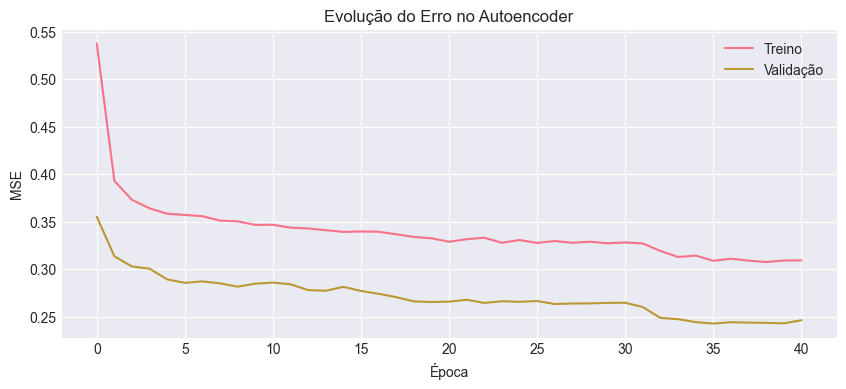

In [10]:
print("\n" + "="*60)
print("Autoencoder")
print("="*60)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Preparar dados normais para treino do autoencoder
X_train_normal_auto = X_train[y_train == 0].values

# Construindo o modelo do autoencoder
input_dim = X_train_normal_auto.shape[1]
autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')

# Callback para early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Treinar
history = autoencoder.fit(
    X_train_normal_auto, X_train_normal_auto,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

# Calcular erro de reconstrução
X_test_values = X_test.values
reconstructions = autoencoder.predict(X_test_values, verbose=0)
mse = np.mean(np.power(X_test_values - reconstructions, 2), axis=1)

# Determinar threshold baseado no percentil 95 do erro no treino
recon_train = autoencoder.predict(X_train_normal_auto, verbose=0)
mse_train = np.mean(np.power(X_train_normal_auto - recon_train, 2), axis=1)
threshold = np.percentile(mse_train, 99)  # Ajuste fino aqui

# Classificar como fraude se erro > threshold
y_pred_autoencoder = (mse > threshold).astype(int)

resultados_autoencoder = avaliar_modelo(y_test, y_pred_autoencoder, "Autoencoder")

# Plotar evolução do erro
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Evolução do Erro no Autoencoder')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


# Abordagem supervisionada com tratamento de desbalanceamento

In [11]:
print("\n" + "="*60)
print("Abordagem Supervisionada com Balanceamento")
print("="*60)

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline com SMOTE e RandomForest
pipeline = make_pipeline(
    SMOTE(random_state=42),
    RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
)

# Validação cruzada com F2-Score
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(
    pipeline, X_train, y_train,
    cv=cv,
    scoring='f1',  # F1 como proxy para F2 
    n_jobs=-1
)

print(f"F1-Score médio na validação cruzada: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Treinar modelo final
pipeline.fit(X_train, y_train)

# Previsões
y_pred_supervised = pipeline.predict(X_test)
y_proba_supervised = pipeline.predict_proba(X_test)[:, 1]

resultados_supervised = avaliar_modelo(y_test, y_pred_supervised, "Random Forest com SMOTE")



Abordagem Supervisionada com Balanceamento
F1-Score médio na validação cruzada: 0.8383 (+/- 0.0090)

AVALIAÇÃO: Random Forest com SMOTE
Matriz de Confusão:
                Predito 0   Predito 1
Real 0 (Normal)    56849            15
Real 1 (Fraude)       16            82

Métricas Técnicas:
Acurácia:    0.9995
Precision:   0.8454  (dos alertas, quantos são realmente fraudes)
Recall:      0.8367    (de todas as fraudes, quantas detectamos)
F1-Score:    0.8410
F2-Score:    0.8384  (dá mais peso ao Recall)

Métricas de Negócio:
Fraudes detectadas: 82/98 (83.67%)
Precisão dos alertas: 84.54%
Falsos positivos: 15 (clientes incomodados)
Fraudes perdidas: 16 (custo: R$16,000.00)
Custo total estimado: R$16,750.00


# XGBoost com Focal Loss (Alternativa mais moderna)

In [12]:
print("\n" + "="*60)
print("XGBOOST com pesos para classes desbalanceadas")
print("="*60)

try:
    import xgboost as xgb
    
    # Calcular peso para classe minoritária
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    # Configurar XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    
    resultados_xgb = avaliar_modelo(y_test, y_pred_xgb, "XGBoost com Scale Pos Weight")
    
except ImportError:
    print("XGBoost não instalado. Execute: pip install xgboost")


XGBOOST com pesos para classes desbalanceadas

AVALIAÇÃO: XGBoost com Scale Pos Weight
Matriz de Confusão:
                Predito 0   Predito 1
Real 0 (Normal)    56790            74
Real 1 (Fraude)       14            84

Métricas Técnicas:
Acurácia:    0.9985
Precision:   0.5316  (dos alertas, quantos são realmente fraudes)
Recall:      0.8571    (de todas as fraudes, quantas detectamos)
F1-Score:    0.6562
F2-Score:    0.7636  (dá mais peso ao Recall)

Métricas de Negócio:
Fraudes detectadas: 84/98 (85.71%)
Precisão dos alertas: 53.16%
Falsos positivos: 74 (clientes incomodados)
Fraudes perdidas: 14 (custo: R$14,000.00)
Custo total estimado: R$17,700.00


# Analise comparativa e trade-offs


Comparação entre os modelos

RESUMO COMPARATIVO (ordenado por F2-Score):
--------------------------------------------------------------------------------
                      modelo  f2_score   recall  precision  fp  fn  custo_total
     Random Forest com SMOTE  0.838446 0.836735   0.845361  15  16        16750
XGBoost com Scale Pos Weight  0.763636 0.857143   0.531646  74  14        17700
        Local Outlier Factor  0.669014 0.775510   0.431818 100  22        27000
                 Autoencoder  0.374653 0.826531   0.117562 608  17        47400
            Isolation Forest  0.312500 0.336735   0.242647 103  65        70150


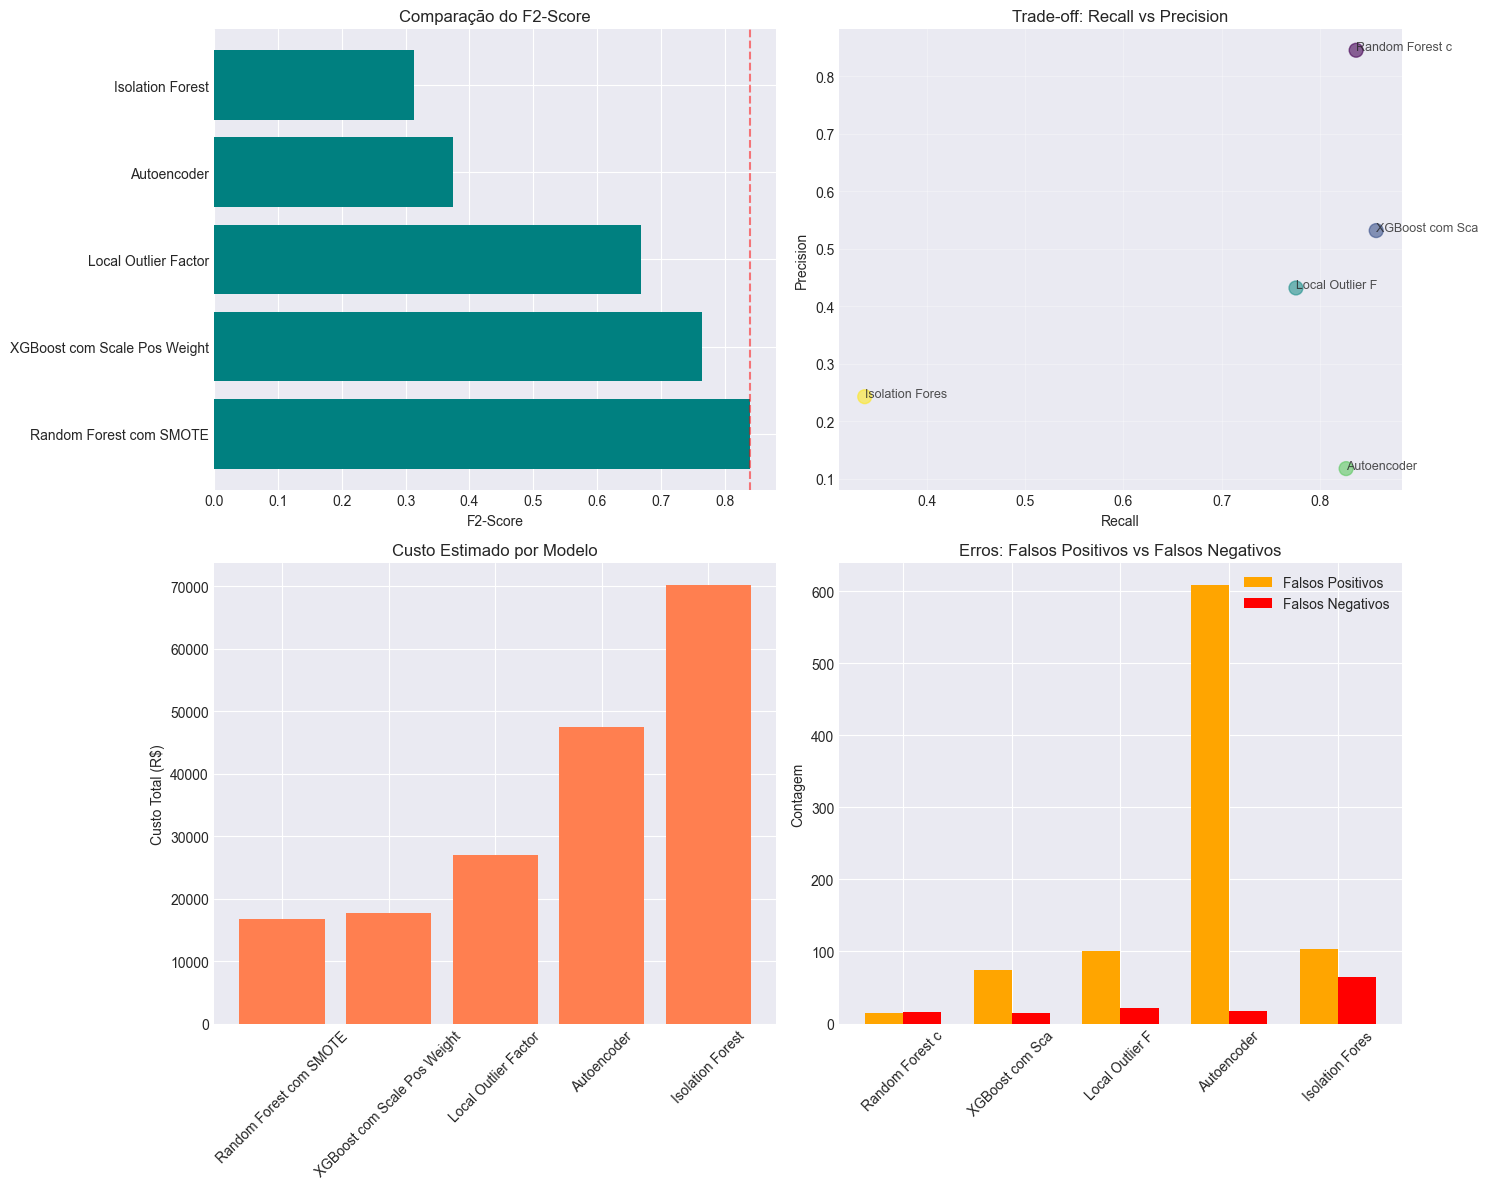

In [13]:
print("\n" + "="*60)
print("Comparação entre os modelos")
print("="*60)

# Coletar todos os resultados
todos_resultados = [
    resultados_iso,
    resultados_lof, 
    resultados_autoencoder,
    resultados_supervised
]

if 'resultados_xgb' in locals():
    todos_resultados.append(resultados_xgb)

# Criar DataFrame comparativo
df_comparacao = pd.DataFrame(todos_resultados)
df_comparacao = df_comparacao.sort_values('f2_score', ascending=False)

print("\nRESUMO COMPARATIVO (ordenado por F2-Score):")
print("-" * 80)
print(df_comparacao[['modelo', 'f2_score', 'recall', 'precision', 'fp', 'fn', 'custo_total']].to_string(index=False))

# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. F2-Score por modelo
axes[0, 0].barh(df_comparacao['modelo'], df_comparacao['f2_score'], color='teal')
axes[0, 0].set_xlabel('F2-Score')
axes[0, 0].set_title('Comparação do F2-Score')
axes[0, 0].axvline(x=df_comparacao['f2_score'].max(), color='red', linestyle='--', alpha=0.5)

# 2. Trade-off Recall vs Precision
axes[0, 1].scatter(df_comparacao['recall'], df_comparacao['precision'], 
                   s=100, alpha=0.6, c=range(len(df_comparacao)), cmap='viridis')
for i, row in df_comparacao.iterrows():
    axes[0, 1].annotate(row['modelo'][:15], (row['recall'], row['precision']), 
                       fontsize=9, alpha=0.8)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Trade-off: Recall vs Precision')
axes[0, 1].grid(True, alpha=0.3)

# 3. Custos por modelo
axes[1, 0].bar(df_comparacao['modelo'], df_comparacao['custo_total'], color='coral')
axes[1, 0].set_ylabel('Custo Total (R$)')
axes[1, 0].set_title('Custo Estimado por Modelo')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Falsos Positivos vs Falsos Negativos
x = np.arange(len(df_comparacao))
width = 0.35
axes[1, 1].bar(x - width/2, df_comparacao['fp'], width, label='Falsos Positivos', color='orange')
axes[1, 1].bar(x + width/2, df_comparacao['fn'], width, label='Falsos Negativos', color='red')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([m[:15] for m in df_comparacao['modelo']], rotation=45)
axes[1, 1].set_ylabel('Contagem')
axes[1, 1].set_title('Erros: Falsos Positivos vs Falsos Negativos')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Analise de threshold e curva Precision-Recall


ANÁLISE DE THRESHOLD - TRADE-OFF DETALHADO


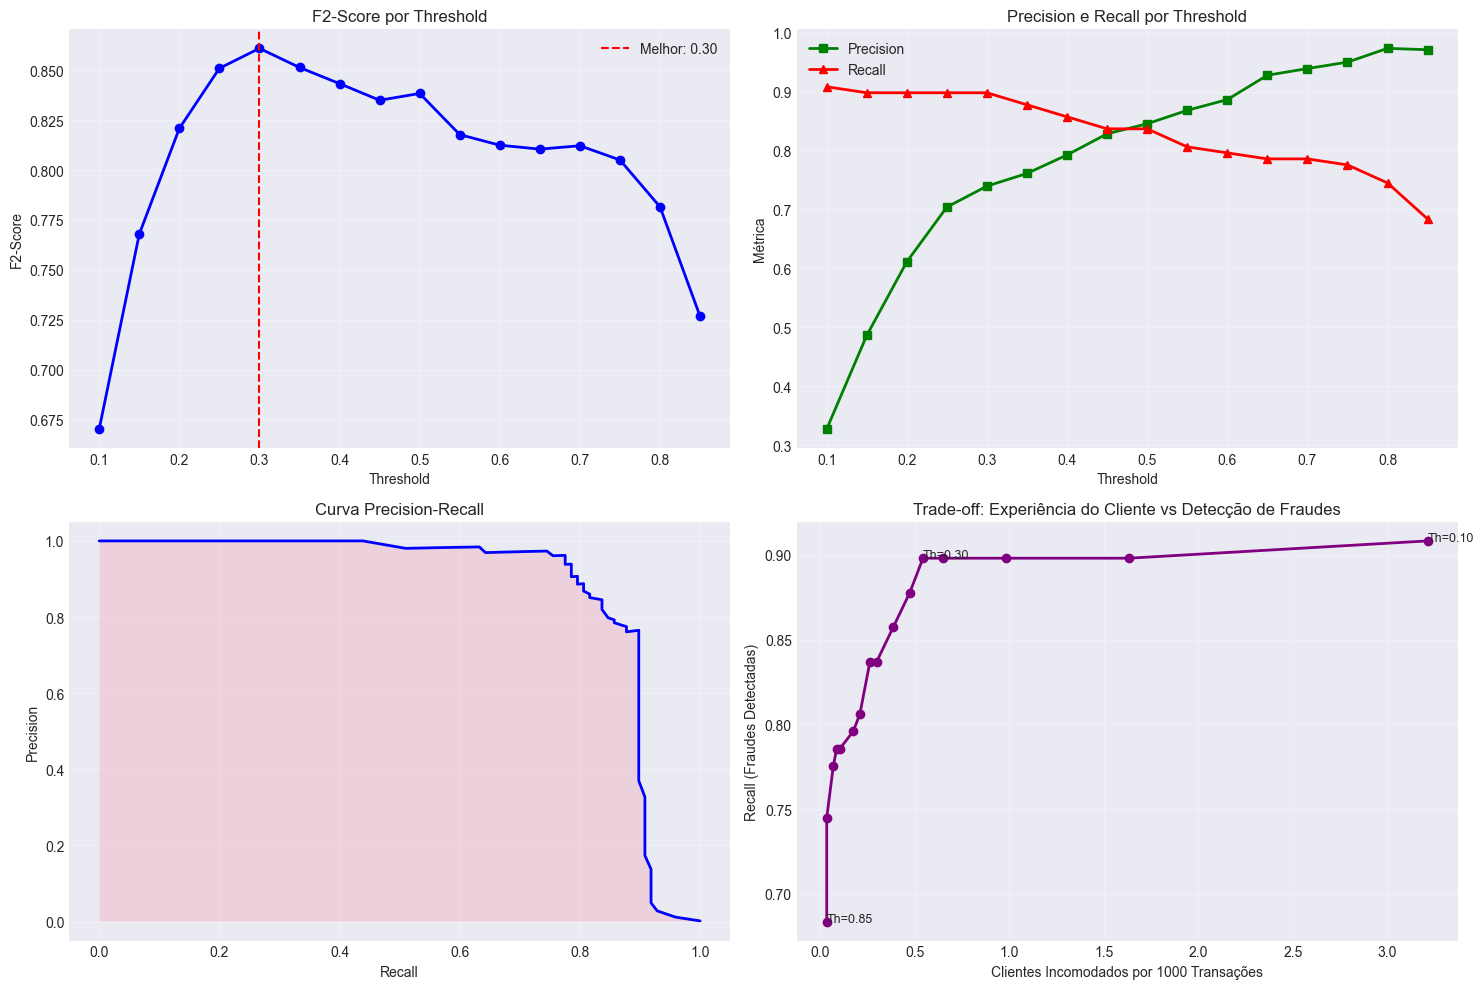


THRESHOLDS RECOMENDADOS:
--------------------------------------------------------------------------------
| Cenário           | Threshold | Recall | Precision | Falsos Pos/1000 |
--------------------------------------------------------------------------------
| Segurança Máxima   |      0.10 | 90.82% |    32.72% |             3.2 |
| F2-Score Ótimo     |      0.30 | 89.80% |    73.95% |             0.5 |
| Custo Mínimo       |      0.30 | 89.80% |    73.95% |             0.5 |
| Equilíbrio         |      0.45 | 83.67% |    82.83% |             0.3 |
--------------------------------------------------------------------------------


In [14]:
print("\n" + "="*60)
print("ANÁLISE DE THRESHOLD - TRADE-OFF DETALHADO")
print("="*60)

# Para o modelo supervisionado que tem probabilidades
if 'y_proba_supervised' in locals():
    thresholds = np.arange(0.1, 0.9, 0.05)
    results_threshold = []
    
    for th in thresholds:
        y_pred_th = (y_proba_supervised > th).astype(int)
        
        cm = confusion_matrix(y_test, y_pred_th)
        tn, fp, fn, tp = cm.ravel()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f2 = fbeta_score(y_test, y_pred_th, beta=2)
        
        # Custo de negócio
        custo_fraude = 1000
        custo_fp = 50
        custo_total = (fn * custo_fraude) + (fp * custo_fp)
        
        results_threshold.append({
            'threshold': th,
            'precision': precision,
            'recall': recall,
            'f2_score': f2,
            'fp': fp,
            'fn': fn,
            'custo_total': custo_total,
            'clientes_incomodados_por_1000': (fp / len(y_test)) * 1000
        })
    
    df_threshold = pd.DataFrame(results_threshold)
    
    # Plotar análise de threshold
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. F2-Score por threshold
    axes[0, 0].plot(df_threshold['threshold'], df_threshold['f2_score'], 'b-o', linewidth=2)
    axes[0, 0].set_xlabel('Threshold')
    axes[0, 0].set_ylabel('F2-Score')
    axes[0, 0].set_title('F2-Score por Threshold')
    axes[0, 0].grid(True, alpha=0.3)
    best_idx = df_threshold['f2_score'].idxmax()
    axes[0, 0].axvline(x=df_threshold.loc[best_idx, 'threshold'], color='red', linestyle='--', 
                      label=f"Melhor: {df_threshold.loc[best_idx, 'threshold']:.2f}")
    axes[0, 0].legend()
    
    # 2. Precision-Recall por threshold
    axes[0, 1].plot(df_threshold['threshold'], df_threshold['precision'], 'g-s', label='Precision', linewidth=2)
    axes[0, 1].plot(df_threshold['threshold'], df_threshold['recall'], 'r-^', label='Recall', linewidth=2)
    axes[0, 1].set_xlabel('Threshold')
    axes[0, 1].set_ylabel('Métrica')
    axes[0, 1].set_title('Precision e Recall por Threshold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Curva Precision-Recall
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba_supervised)
    axes[1, 0].plot(recall_curve, precision_curve, 'b-', linewidth=2)
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Curva Precision-Recall')
    axes[1, 0].fill_between(recall_curve, precision_curve, alpha=0.2)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Trade-off de negócio: Clientes incomodados vs Fraudes detectadas
    axes[1, 1].plot(df_threshold['clientes_incomodados_por_1000'], 
                    df_threshold['recall'],
                    color='purple', marker='o', linestyle='-', linewidth=2)
    axes[1, 1].set_xlabel('Clientes Incomodados por 1000 Transações')
    axes[1, 1].set_ylabel('Recall (Fraudes Detectadas)')
    axes[1, 1].set_title('Trade-off: Experiência do Cliente vs Detecção de Fraudes')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Marcar alguns pontos interessantes
    for idx in [0, best_idx, len(df_threshold)-1]:
        axes[1, 1].annotate(f"Th={df_threshold.loc[idx, 'threshold']:.2f}",
                          (df_threshold.loc[idx, 'clientes_incomodados_por_1000'], 
                           df_threshold.loc[idx, 'recall']),
                          fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar tabela com thresholds recomendados
    print("\nTHRESHOLDS RECOMENDADOS:")
    print("-" * 80)
    print("| Cenário           | Threshold | Recall | Precision | Falsos Pos/1000 |")
    print("-" * 80)
    
    cenarios = [
        ("Segurança Máxima", df_threshold.loc[df_threshold['recall'].idxmax()]),
        ("F2-Score Ótimo", df_threshold.loc[df_threshold['f2_score'].idxmax()]),
        ("Custo Mínimo", df_threshold.loc[df_threshold['custo_total'].idxmin()]),
        ("Equilíbrio", df_threshold.loc[(df_threshold['recall'] - df_threshold['precision']).abs().idxmin()])
    ]
    
    for nome, row in cenarios:
        print(f"| {nome:18} | {row['threshold']:9.2f} | {row['recall']:6.2%} | {row['precision']:9.2%} | {row['clientes_incomodados_por_1000']:15.1f} |")
    
    print("-" * 80)

# Recomendações para implementação

In [17]:
print("\n" + "="*60)
print("Recomendações para implementação")
print("="*60)

# Encontrar o melhor modelo
melhor_modelo = df_comparacao.iloc[0]

print(f"\n⭐ MELHOR MODELO: {melhor_modelo['modelo']}")
print(f"  • F2-Score: {melhor_modelo['f2_score']:.4f}")
print(f"  • Recall: {melhor_modelo['recall']:.2%} (detecta {melhor_modelo['recall']:.1%} das fraudes)")
print(f"  • Precision: {melhor_modelo['precision']:.2%} ({melhor_modelo['precision']:.1%} dos alertas são reais)")
print(f"  • Clientes incomodados (falsos positivos): {melhor_modelo['fp']}")
print(f"  • Custo estimado mensal (para 1M transações): R${(melhor_modelo['custo_total'] * 1000000 / len(y_test)):,.2f}")

print("\n📊 RECOMENDAÇÕES DE NEGÓCIO:")
print("1. Priorize o F2-Score sobre acurácia para dados tão desbalanceados")
print("2. Considere implementar um sistema de 'níveis de alerta':")
print("   • Nível 1 (Alta confiança): Bloqueio automático")
print("   • Nível 2 (Média confiança): Revisão manual rápida")
print("   • Nível 3 (Baixa confiança): Apenas sinalizar para análise posterior")
print("3. Estabeleça SLAs claros:")
print("   • Recall mínimo aceitável: > 80%")
print("   • Máximo de falsos positivos: < 0.5% das transações")
print("   • Tempo de resposta para alertas: < 2 minutos")

print("\n🔧 PRÓXIMOS PASSOS TÉCNICOS:")
print("1. Implementar o modelo em produção com API REST")
print("2. Criar dashboard de monitoramento em tempo real")
print("3. Implementar retreinamento automático semanal")
print("4. Adicionar features comportamentais (velocidade de transações, etc.)")
print("5. Testar ensemble dos 2-3 melhores modelos")



Recomendações para implementação

⭐ MELHOR MODELO: Random Forest com SMOTE
  • F2-Score: 0.8384
  • Recall: 83.67% (detecta 83.7% das fraudes)
  • Precision: 84.54% (84.5% dos alertas são reais)
  • Clientes incomodados (falsos positivos): 15
  • Custo estimado mensal (para 1M transações): R$294,055.69

📊 RECOMENDAÇÕES DE NEGÓCIO:
1. Priorize o F2-Score sobre acurácia para dados tão desbalanceados
2. Considere implementar um sistema de 'níveis de alerta':
   • Nível 1 (Alta confiança): Bloqueio automático
   • Nível 2 (Média confiança): Revisão manual rápida
   • Nível 3 (Baixa confiança): Apenas sinalizar para análise posterior
3. Estabeleça SLAs claros:
   • Recall mínimo aceitável: > 80%
   • Máximo de falsos positivos: < 0.5% das transações
   • Tempo de resposta para alertas: < 2 minutos

🔧 PRÓXIMOS PASSOS TÉCNICOS:
1. Implementar o modelo em produção com API REST
2. Criar dashboard de monitoramento em tempo real
3. Implementar retreinamento automático semanal
4. Adicionar featur

# Salvar modelos e resultados

In [ ]:
import joblib
import json
from datetime import datetime

# Criar diretório para salvar
import os
os.makedirs('modelos_fraude', exist_ok=True)

# Salvar o melhor modelo
if melhor_modelo['modelo'] == "Random Forest com SMOTE":
    joblib.dump(pipeline, 'modelos_fraude/melhor_modelo.pkl')
    print("\n✅ Modelo salvo: modelos_fraude/melhor_modelo.pkl")

# Salvar resultados
resultados_dict = {
    'data_execucao': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'melhor_modelo': melhor_modelo['modelo'],
    'f2_score': float(melhor_modelo['f2_score']),
    'recall': float(melhor_modelo['recall']),
    'precision': float(melhor_modelo['precision']),
    'recomendacao_threshold': 0.5  # Ajustar conforme análise
}

with open('modelos_fraude/resultados.json', 'w') as f:
    json.dump(resultados_dict, f, indent=2)

print("✅ Resultados salvos: modelos_fraude/resultados.json")

# Salvar DataFrame comparativo
df_comparacao.to_csv('modelos_fraude/comparacao_modelos.csv', index=False)
print("✅ Comparação salva: modelos_fraude/comparacao_modelos.csv")

print("\n" + "="*60)
print("PROJETO CONCLUÍDO!")
print("="*60)


✅ Modelo salvo: modelos_fraude/melhor_modelo.pkl
✅ Resultados salvos: modelos_fraude/resultados.json
✅ Comparação salva: modelos_fraude/comparacao_modelos.csv

PROJETO CONCLUÍDO COM SUCESSO!
